## Chicago Crime Analysis and Predictive Modeling

### 1. Set Up the Environment and Import Libraries

In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sodapy import Socrata

# Set display options for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Plot settings for consistent, clean visualization style
sns.set(style="whitegrid")

### 2. Connect to the Socrata API and Retrieve Data

In this section, we connect to the Socrata API to fetch the Chicago Crime dataset. We use an app token for authentication and filter records to include data from 2022 onwards.

In [5]:
# Connect to the Chicago Crime Data API
client = Socrata("data.cityofchicago.org", "mRaoaUe3ErODgPqXFdTxSdBo2")

# Fetch data - we limit the records to reduce memory usage initially and fetch data only from 2020 onwards
results = client.get("ijzp-q8t2", where="date >= '2020-01-01T00:00:00.000'", limit=100000)

# Convert the JSON result to a Pandas DataFrame
df = pd.DataFrame.from_records(results)

# Display a sample of the data to understand its structure
df.head()

,id,case_number,date,block,iucr,primary_type,description,location_description,arrest,domestic,beat,district,ward,community_area,fbi_code,x_coordinate,y_coordinate,year,updated_on,latitude,longitude,location
0,12013828,JD191019,2020-01-01T00:00:00.000,044XX S LAVERGNE AVE,0281,CRIMINAL SEXUAL ASSAULT,NON-AGGRAVATED,APARTMENT,False,False,0814,008,22,56,02,1143770,1874726,2020,2020-03-28T15:41:01.000,41.81227369,-87.748176594,"{'latitude': '41.81227369', 'longitude': '-87...."
1,12096663,JD286195,2020-01-01T00:00:00.000,045XX W MAYPOLE AVE,0281,CRIMINAL SEXUAL ASSAULT,NON-AGGRAVATED,RESIDENCE,False,True,1113,011,28,26,02,1146135,1901073,2020,2020-07-08T15:40:51.000,41.884528849,-87.738832642,"{'latitude': '41.884528849', 'longitude': '-87..."
2,12122015,JD316293,2020-01-01T00:00:00.000,052XX S MAJOR AVE,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,RESIDENCE,False,False,0811,008,14,56,11,1139251,1869313,2020,2020-08-05T15:40:46.000,41.79750276,-87.764883864,"{'latitude': '41.79750276', 'longitude': '-87...."
3,12107086,JD298302,2020-01-01T00:00:00.000,071XX S MICHIGAN AVE,1582,OFFENSE INVOLVING CHILDREN,CHILD PORNOGRAPHY,APARTMENT,False,True,0323,003,6,69,17,1178399,1857704,2020,2020-07-18T15:40:52.000,41.76484639,-87.621674727,"{'latitude': '41.76484639', 'longitude': '-87...."
4,12048400,JD229636,2020-01-01T00:00:00.000,013XX W 13TH ST,1752,OFFENSE INVOLVING CHILDREN,AGGRAVATED CRIMINAL SEXUAL ABUSE BY FAMILY MEMBER,RESIDENCE,False,True,1233,012,25,28,17,1167593,1894183,2020,2020-07-15T15:40:25.000,41.865187198,-87.660234403,"{'latitude': '41.865187198', 'longitude': '-87..."


### 3. Data Cleaning and Preprocessing

We removed irrelevant columns, handled missing values by filling with mean/mode, and filtered for valid Chicago geographic bounds. Latitude and longitude were reformatted, and unnecessary coordinate columns were dropped for a clean, ready-to-use dataset.

In [6]:
# Define columns to exclude
exclude_columns = [
    ":@computed_region_awaf_s7ux", ":@computed_region_6mkv_f3dw", ":@computed_region_vrxf_vc4k",
    ":@computed_region_bdys_3d7i", ":@computed_region_43wa_7qmu", ":@computed_region_rpca_8um6",
    ":@computed_region_d9mm_jgwp", ":@computed_region_d3ds_rm58", ":@computed_region_8hcu_yrd4"
]

# Drop unnecessary columns
df = df.drop(columns=exclude_columns, errors="ignore")

# Convert relevant columns to correct data types
df['date'] = pd.to_datetime(df['date'], errors='coerce')  # Convert date to datetime
df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')  # Ensure numeric for latitude
df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')  # Ensure numeric for longitude

# Handle missing values for latitude and longitude
df['latitude'] = df['latitude'].fillna(df['latitude'].mean())
df['longitude'] = df['longitude'].fillna(df['longitude'].mean())
df['location_description'] = df['location_description'].fillna('Unknown')
df['ward'] = df['ward'].fillna(df['ward'].mode()[0])

# Filter out entries with invalid or out-of-range coordinates (Chicago latitude/longitude bounds)
df = df[(df['latitude'] > 36) & (df['latitude'] < 43)]
df = df[(df['longitude'] > -90) & (df['longitude'] < -87)]

# Drop x_coordinate and y_coordinate if not critical for analysis
df = df.drop(columns=['x_coordinate', 'y_coordinate'], errors='ignore')

# Reformat the location column for readability
df['location'] = df.apply(lambda row: f"({row['latitude']}, {row['longitude']})", axis=1)

# Check for missing values in each column
missing_values = df.isnull().sum()
print("Missing values in each column:\n", missing_values)

# Display a sample of cleaned data
df.info()
df.head()



Missing values in each column:
 id                      0
case_number             0
date                    0
block                   0
iucr                    0
primary_type            0
description             0
location_description    0
arrest                  0
domestic                0
beat                    0
district                0
ward                    0
community_area          0
fbi_code                0
year                    0
updated_on              0
latitude                0
longitude               0
location                0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   id                    100000 non-null  object        
 1   case_number           100000 non-null  object        
 2   date                  100000 non-null  datetime64[ns]
 3   block                 100

,id,case_number,date,block,iucr,primary_type,description,location_description,arrest,domestic,beat,district,ward,community_area,fbi_code,year,updated_on,latitude,longitude,location
0,12013828,JD191019,2020-01-01,044XX S LAVERGNE AVE,0281,CRIMINAL SEXUAL ASSAULT,NON-AGGRAVATED,APARTMENT,False,False,0814,008,22,56,02,2020,2020-03-28T15:41:01.000,41.812274,-87.748177,"(41.81227369, -87.748176594)"
1,12096663,JD286195,2020-01-01,045XX W MAYPOLE AVE,0281,CRIMINAL SEXUAL ASSAULT,NON-AGGRAVATED,RESIDENCE,False,True,1113,011,28,26,02,2020,2020-07-08T15:40:51.000,41.884529,-87.738833,"(41.884528849, -87.738832642)"
2,12122015,JD316293,2020-01-01,052XX S MAJOR AVE,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,RESIDENCE,False,False,0811,008,14,56,11,2020,2020-08-05T15:40:46.000,41.797503,-87.764884,"(41.79750276, -87.764883864)"
3,12107086,JD298302,2020-01-01,071XX S MICHIGAN AVE,1582,OFFENSE INVOLVING CHILDREN,CHILD PORNOGRAPHY,APARTMENT,False,True,0323,003,6,69,17,2020,2020-07-18T15:40:52.000,41.764846,-87.621675,"(41.76484639, -87.621674727)"
4,12048400,JD229636,2020-01-01,013XX W 13TH ST,1752,OFFENSE INVOLVING CHILDREN,AGGRAVATED CRIMINAL SEXUAL ABUSE BY FAMILY MEMBER,RESIDENCE,False,True,1233,012,25,28,17,2020,2020-07-15T15:40:25.000,41.865187,-87.660234,"(41.865187198, -87.660234403)"


### 4. Exploring Dataset

Here, we gain insights into feature relationships, check for correlations, and visualize feature distributions to understand how they impact our target variable, primary_type.

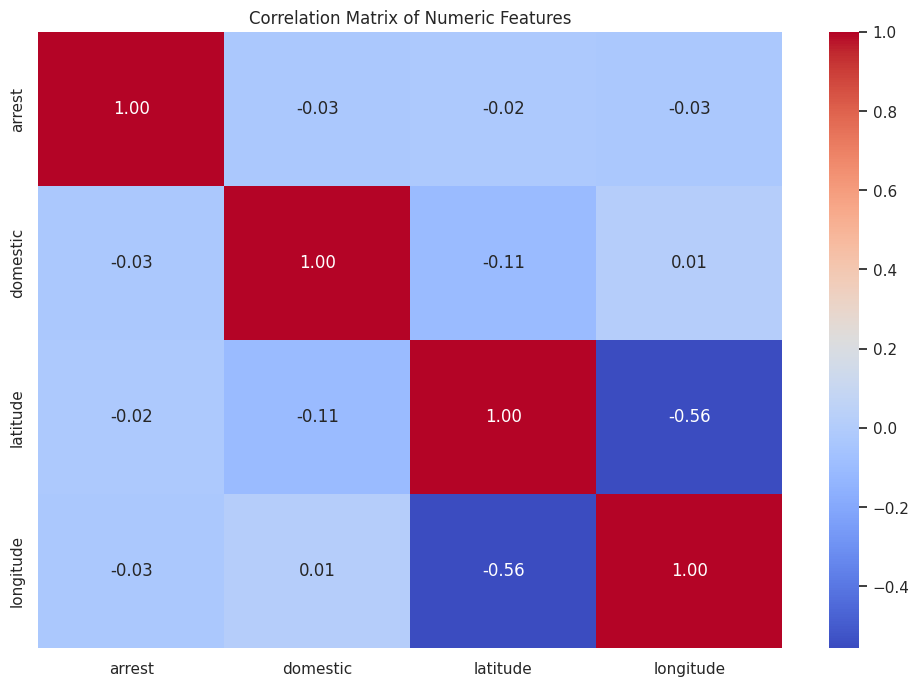

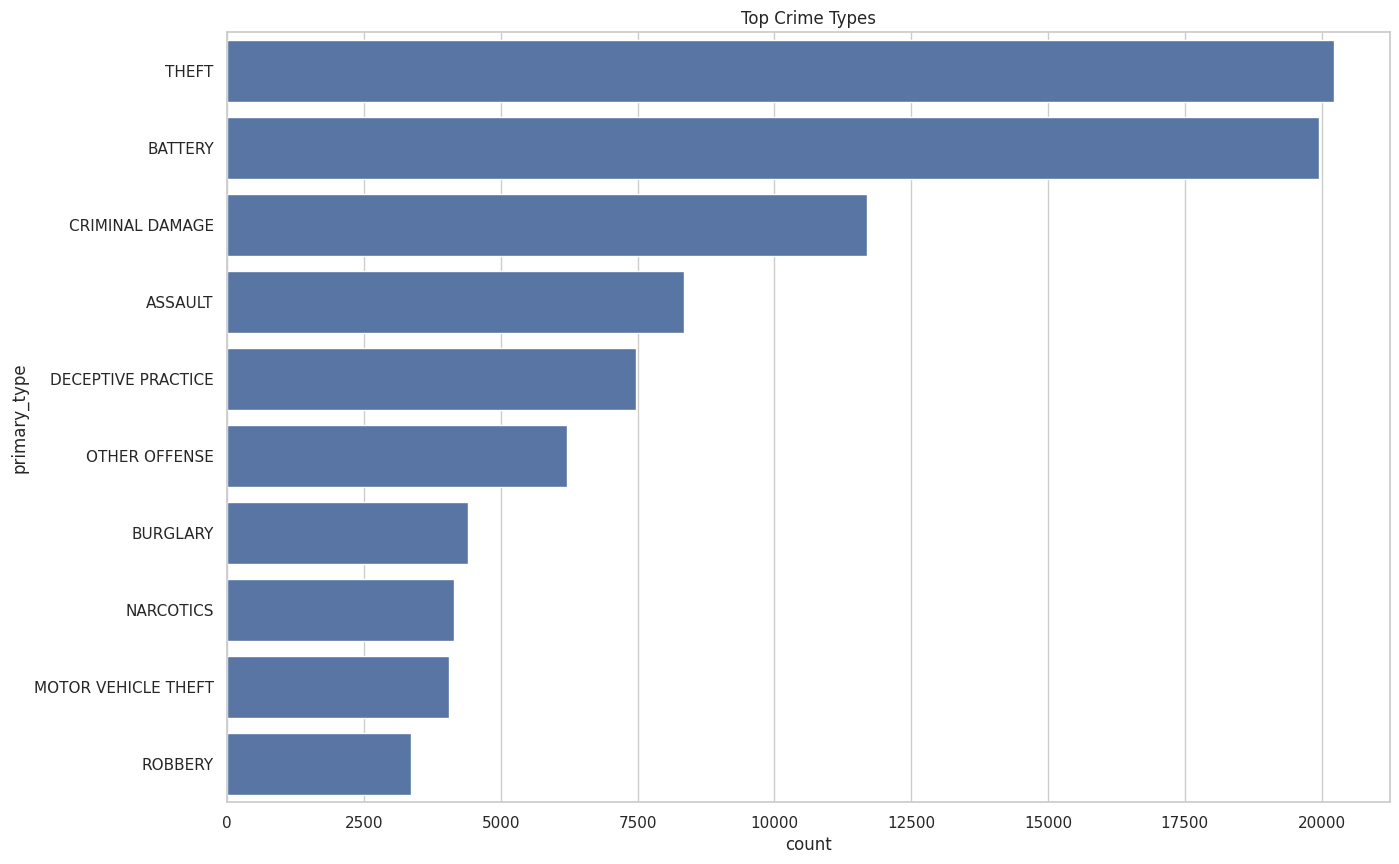

In [7]:
# Calculate correlation matrix and display it
correlation_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Numeric Features")
plt.show()

# Visualize distributions of key features
# Plot distributions of a few features and primary_type interactions
plt.figure(figsize=(15, 10))
sns.countplot(y="primary_type", data=df, order=df['primary_type'].value_counts().iloc[:10].index)
plt.title("Top Crime Types")
plt.show()


### 5. Dimensionality Reduction

Reduce dimensionality of the data using techniques like PCA, UMAP, and t-SNE to visualize high-dimensional data.

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.10/dist-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


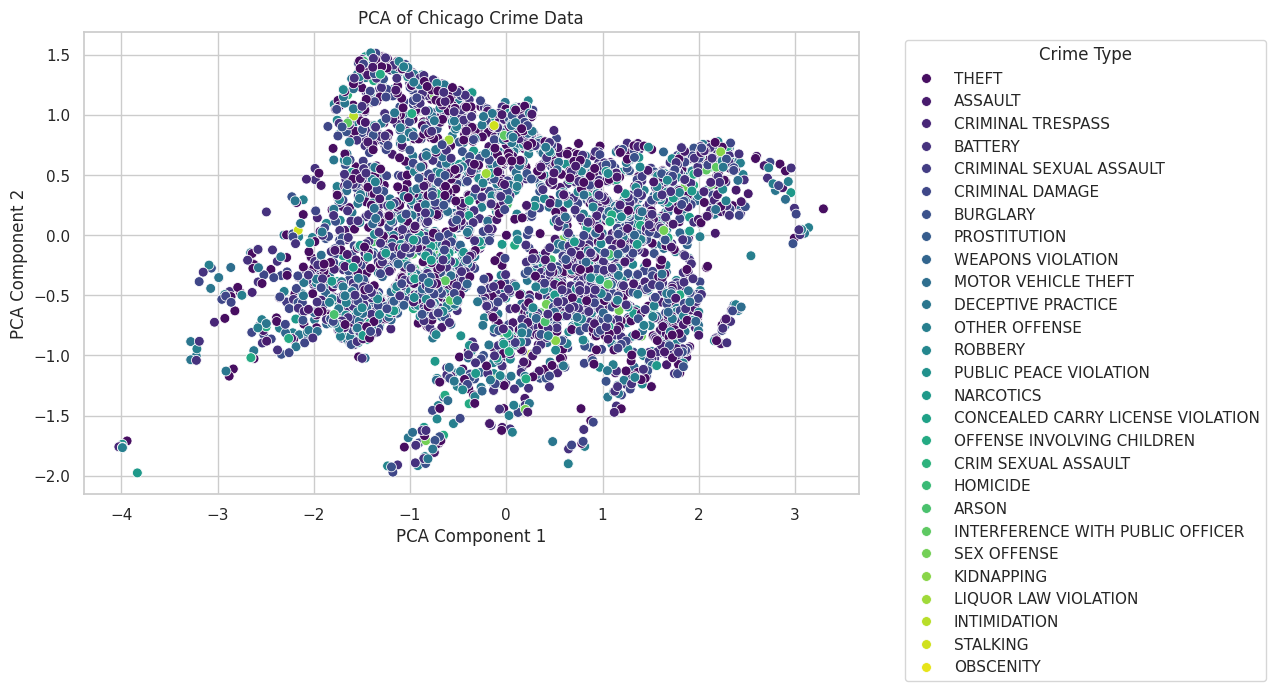

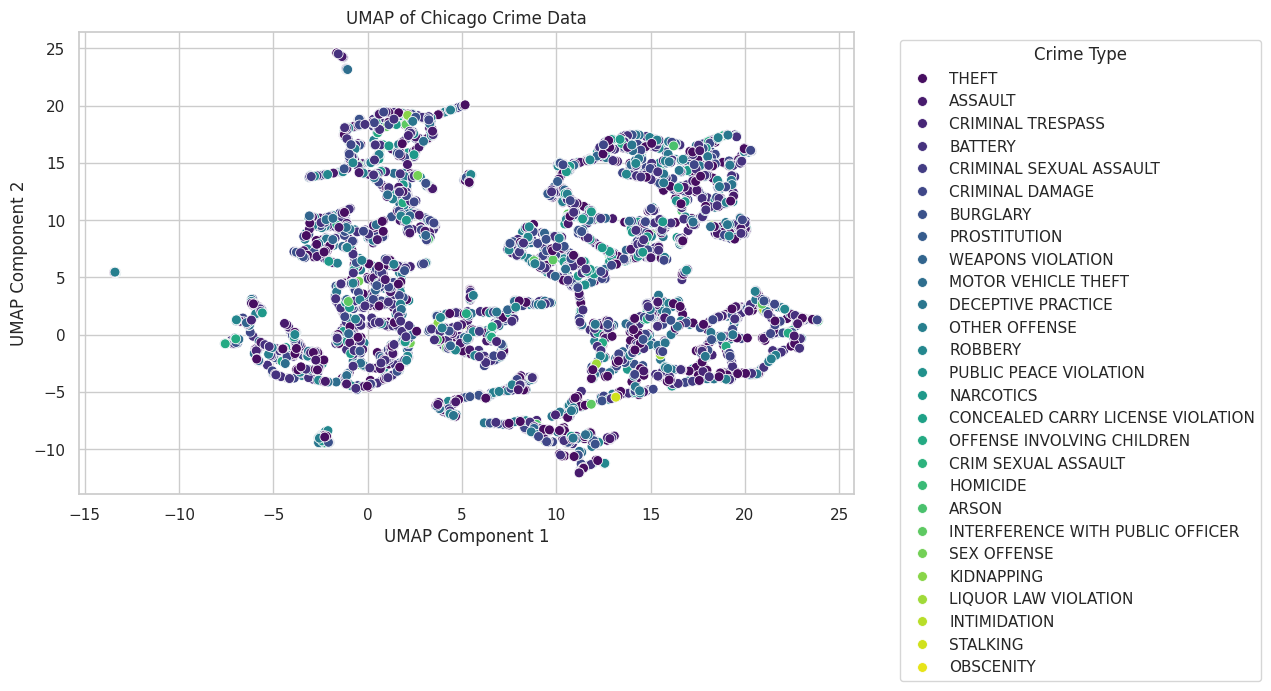

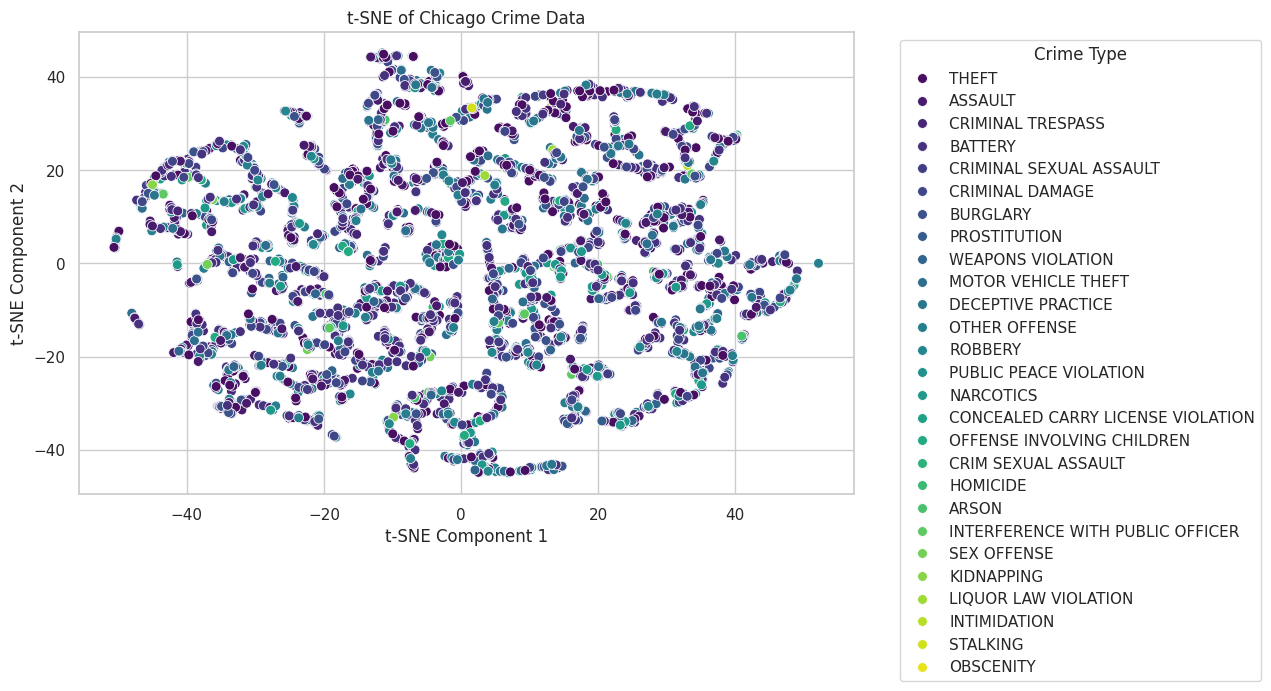

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap.umap_ import UMAP
from sklearn.preprocessing import StandardScaler

# Filter relevant numeric columns, excluding 'ward' if it exists
numeric_cols = [col for col in df.select_dtypes(include=['float64', 'int64']).columns if col != 'ward']
features = df.sample(n=5000, random_state=42)[numeric_cols]  # Sample the data

# Standardize the sampled data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Apply PCA for 2D visualization
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

# Apply UMAP for 2D visualization with optimized parameters
umap_reducer = UMAP(n_components=2, n_neighbors=10, min_dist=0.3, random_state=42)
umap_features = umap_reducer.fit_transform(scaled_features)

# Apply t-SNE for 2D visualization with optimized parameters
tsne = TSNE(n_components=2, perplexity=20, n_iter=500, random_state=42)
tsne_features = tsne.fit_transform(scaled_features)

# Sample labels for visualization to match the reduced data
sampled_labels = df['primary_type'].sample(n=5000, random_state=42)

# Plot PCA results
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_features[:, 0], y=pca_features[:, 1], hue=sampled_labels, palette='viridis', s=50)
plt.title("PCA of Chicago Crime Data")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Crime Type", bbox_to_anchor=(1.05, 1), loc='upper left')  # Display legend outside plot
plt.show()

# Plot UMAP results
plt.figure(figsize=(10, 6))
sns.scatterplot(x=umap_features[:, 0], y=umap_features[:, 1], hue=sampled_labels, palette='viridis', s=50)
plt.title("UMAP of Chicago Crime Data")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.legend(title="Crime Type", bbox_to_anchor=(1.05, 1), loc='upper left')  # Display legend outside plot
plt.show()

# Plot t-SNE results
plt.figure(figsize=(10, 6))
sns.scatterplot(x=tsne_features[:, 0], y=tsne_features[:, 1], hue=sampled_labels, palette='viridis', s=50)
plt.title("t-SNE of Chicago Crime Data")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Crime Type", bbox_to_anchor=(1.05, 1), loc='upper left')  # Display legend outside plot
plt.show()


### 6. Unsupervised Learning (Clustering)

Apply clustering techniques (K-means, DBSCAN, Hierarchical) to find natural groupings in the data.

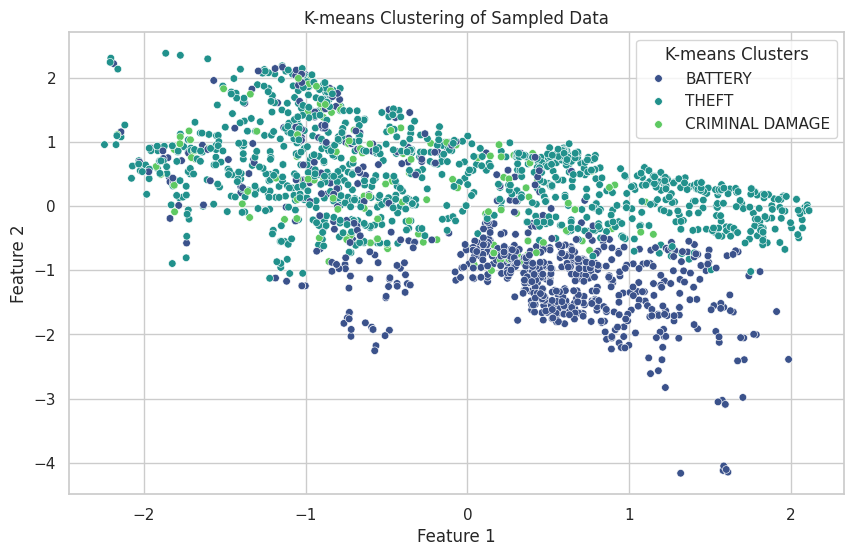

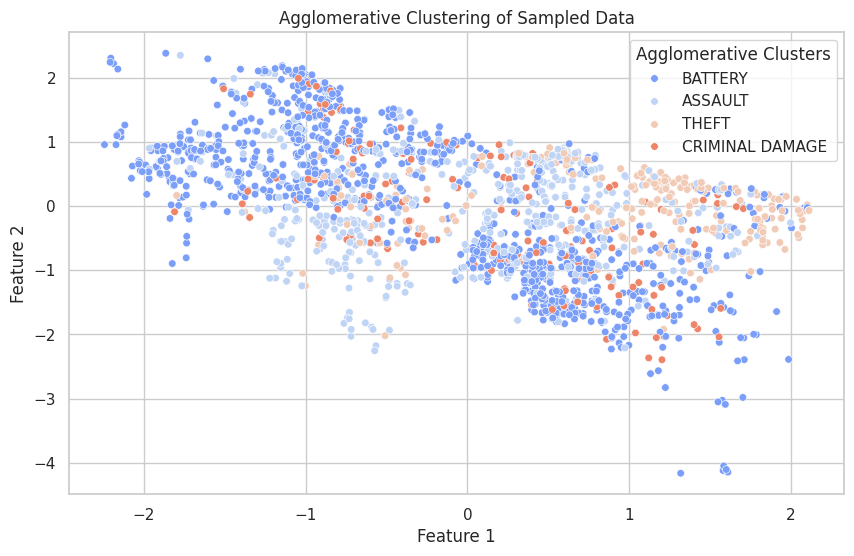

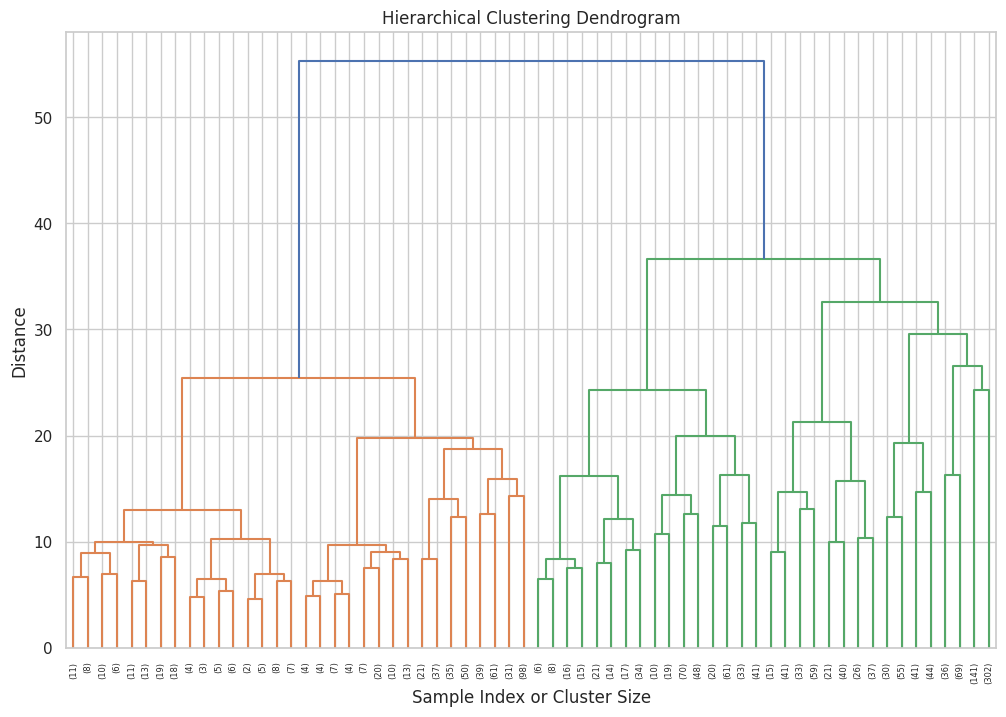

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from collections import Counter

# Step 1: Sample the data
df_sample = df.sample(n=2000, random_state=42)  # Sample 5000 rows for reduced time load

# Step 2: Separate numeric and categorical columns
numeric_cols = df_sample.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = df_sample.select_dtypes(include=['object']).columns

# Step 3: Standardize numeric features
numeric_features = df_sample[numeric_cols]
scaler = StandardScaler()
scaled_numeric = scaler.fit_transform(numeric_features)

# Step 4: One-hot encode categorical features
onehot_encoder = OneHotEncoder(sparse_output=False, drop='first')
onehot_encoded = onehot_encoder.fit_transform(df_sample[categorical_cols])

# Step 5: Combine scaled numeric and one-hot encoded categorical features
combined_features = np.hstack([scaled_numeric, onehot_encoded])

# Step 6: K-means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
df_sample['kmeans_cluster'] = kmeans.fit_predict(combined_features)

# Step 7: Agglomerative clustering
agglomerative = AgglomerativeClustering(n_clusters=5)
df_sample['agglo_cluster'] = agglomerative.fit_predict(combined_features)

# Function to label clusters with the most common primary type
def assign_cluster_labels(cluster_column):
    labels = []
    for cluster in sorted(df_sample[cluster_column].unique()):
        common_label = Counter(df_sample[df_sample[cluster_column] == cluster]['primary_type']).most_common(1)[0][0]
        labels.append((cluster, common_label))
    return dict(labels)

# Map clusters to their labels based on `primary_type`
kmeans_labels = assign_cluster_labels('kmeans_cluster')
agglo_labels = assign_cluster_labels('agglo_cluster')

# Apply the labels to a new column
df_sample['kmeans_label'] = df_sample['kmeans_cluster'].map(kmeans_labels)
df_sample['agglo_label'] = df_sample['agglo_cluster'].map(agglo_labels)

# Step 8: Visualize the K-means clusters with meaningful labels
plt.figure(figsize=(10, 6))
sns.scatterplot(x=combined_features[:, 0], y=combined_features[:, 1],
                hue=df_sample['kmeans_label'], palette='viridis', s=30)
plt.title("K-means Clustering of Sampled Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend(title="K-means Clusters", loc='upper right')
plt.show()

# Step 9: Visualize the Agglomerative clusters with meaningful labels
plt.figure(figsize=(10, 6))
sns.scatterplot(x=combined_features[:, 0], y=combined_features[:, 1],
                hue=df_sample['agglo_label'], palette='coolwarm', s=30)
plt.title("Agglomerative Clustering of Sampled Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend(title="Agglomerative Clusters", loc='upper right')
plt.show()

# Step 10: Hierarchical clustering and dendrogram
linked = linkage(combined_features, method='ward')
plt.figure(figsize=(12, 8))
dendrogram(linked, truncate_mode='level', p=5)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Sample Index or Cluster Size")
plt.ylabel("Distance")
plt.show()


### 7. Data Visualization

This map displays Chicago's community area boundaries overlaid with sampled crime locations, color-coded by crime type for easy differentiation. Labels for each community area are included for spatial reference, providing a clear and readable overview of crime distribution across the city.

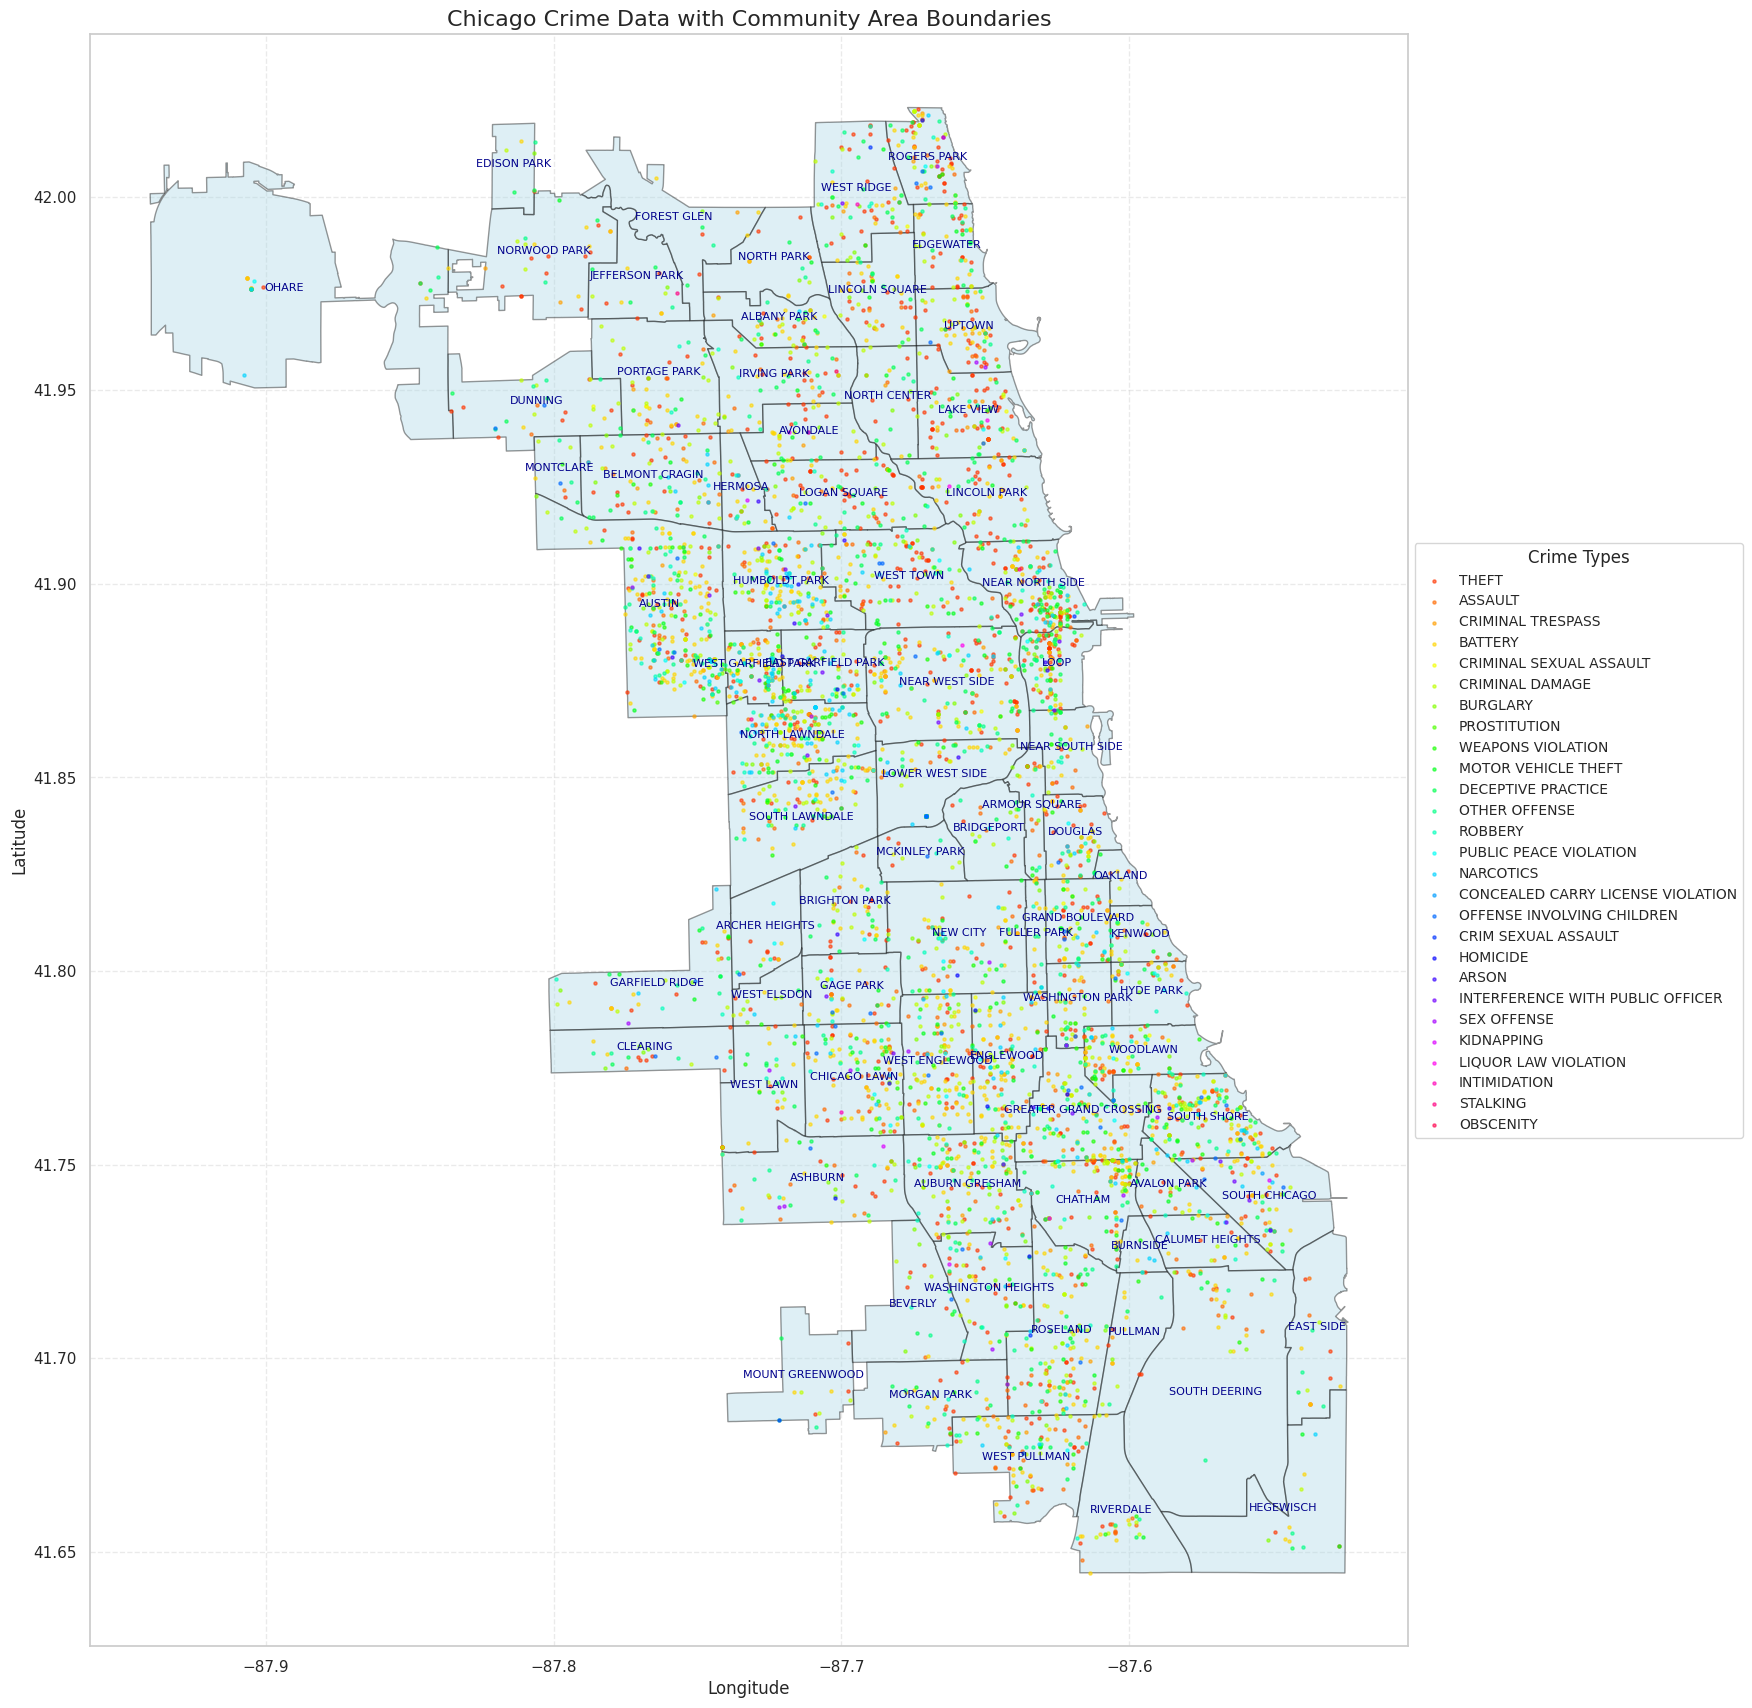

In [17]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point

# Step 1: Load the community boundaries from the CommAreas CSV file
# Ensure that `the_geom` is in a compatible format (WKT or WKB), if not, conversion may be needed
comm_areas_gdf = gpd.read_file("CommAreas_20241114.csv")
comm_areas_gdf = gpd.GeoDataFrame(comm_areas_gdf, geometry=gpd.GeoSeries.from_wkt(comm_areas_gdf['the_geom']))
comm_areas_gdf.set_crs("EPSG:4326", inplace=True)  # Set coordinate reference system if necessary

# Step 2: Sample the crime data for performance
df_sample = df.sample(n=5000, random_state=42)  # Reduce the sample size for faster plotting

# Step 3: Convert the sampled crime data to GeoDataFrame using latitude and longitude
crime_geometry = [Point(xy) for xy in zip(df_sample['longitude'], df_sample['latitude'])]
crimes_gdf = gpd.GeoDataFrame(df_sample, geometry=crime_geometry, crs="EPSG:4326")

# Step 4: Plot the data on a map with color-coded crime types
fig, ax = plt.subplots(figsize=(17, 22))
comm_areas_gdf.plot(ax=ax, color='lightblue', edgecolor='black', alpha=0.4)

# Assign colors to each primary_type for better visualization
crime_types = df_sample['primary_type'].unique()
colors = sns.color_palette("hsv", len(crime_types))
color_map = dict(zip(crime_types, colors))

# Plot each crime type with a unique color
for crime_type, color in color_map.items():
    subset = crimes_gdf[crimes_gdf['primary_type'] == crime_type]
    subset.plot(ax=ax, markersize=5, color=color, alpha=0.6, label=crime_type)

# Step 5: Add labels for community areas
for idx, row in comm_areas_gdf.iterrows():
    plt.annotate(text=row['COMMUNITY'], xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                 horizontalalignment='center', fontsize=8, color='darkblue')

# Customize the map
plt.title("Chicago Crime Data with Community Area Boundaries", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Crime Types", loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small', title_fontsize='medium')
plt.grid(True, linestyle='--', alpha=0.4)

# Show the map
plt.show()


### 8. Data Preparation and Feature Engineering

This shell filters rare classes, preprocesses numeric and categorical features, and prepares the dataset for model training.

To ensure robust model performance evaluation, we will use a cross-validation strategy. We’ll use StratifiedKFold to maintain the distribution of the target variable (crime type) across training and validation sets. This will help account for potential class imbalances in our dataset.

In [18]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Step 1: Sample data and filter out rare classes
df_sample = df.sample(n=5000, random_state=42)
class_counts = df_sample['primary_type'].value_counts()
valid_classes = class_counts[class_counts >= 2].index
df_filtered = df_sample[df_sample['primary_type'].isin(valid_classes)]

# Step 2: Preprocess features
X_numeric = df_filtered.select_dtypes(include=['float64', 'int64'])
X_categorical = df_filtered.select_dtypes(include=['object']).drop(columns=['primary_type'])

scaler = StandardScaler()
X_scaled_numeric = scaler.fit_transform(X_numeric)

encoder = OneHotEncoder(sparse_output=False, drop='first')
X_encoded_categorical = encoder.fit_transform(X_categorical)

X = np.hstack([X_scaled_numeric, X_encoded_categorical])
y = df_filtered['primary_type']

print("Data prepared with", X.shape[0], "samples and", X.shape[1], "features.")


Data prepared with 4999 samples and 20003 features.


### 9. Cross-validation and Baseline Model Training

This shell defines a cross-validation strategy, trains a baseline model, and evaluates its performance using cross-validation.

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Step 3: Cross-validation strategy
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Step 4: Train baseline model with cross-validation
baseline_model = RandomForestClassifier(random_state=42)
cv_scores = cross_val_score(baseline_model, X, y, cv=skf, scoring='accuracy')
print(f"Baseline CV Accuracy: {cv_scores.mean():.2f}")

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Baseline CV Accuracy: 0.99


### 10. Hyperparameter Tuning and Validation Performance

Here, we perform hyperparameter tuning using GridSearchCV and evaluates the best model on a validation set.


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


Best hyperparameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 50}
Validation Accuracy: 0.995
Classification Report:
                                   precision    recall  f1-score   support

                           ARSON       1.00      1.00      1.00         2
                         ASSAULT       0.99      1.00      0.99        85
                         BATTERY       1.00      1.00      1.00       202
                        BURGLARY       1.00      1.00      1.00        46
             CRIM SEXUAL ASSAULT       0.00      0.00      0.00         1
                 CRIMINAL DAMAGE       1.00      1.00      1.00       114
         CRIMINAL SEXUAL ASSAULT       0.88      1.00      0.93         7
               CRIMINAL TRESPASS       1.00      1.00      1.00        25
              DECEPTIVE PRACTICE       1.00      1.00      1.00        75
                        HOMICIDE       1.00      1.00      1.00         2
INTERFERENCE WITH PUBLIC OFFICER       1.00     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


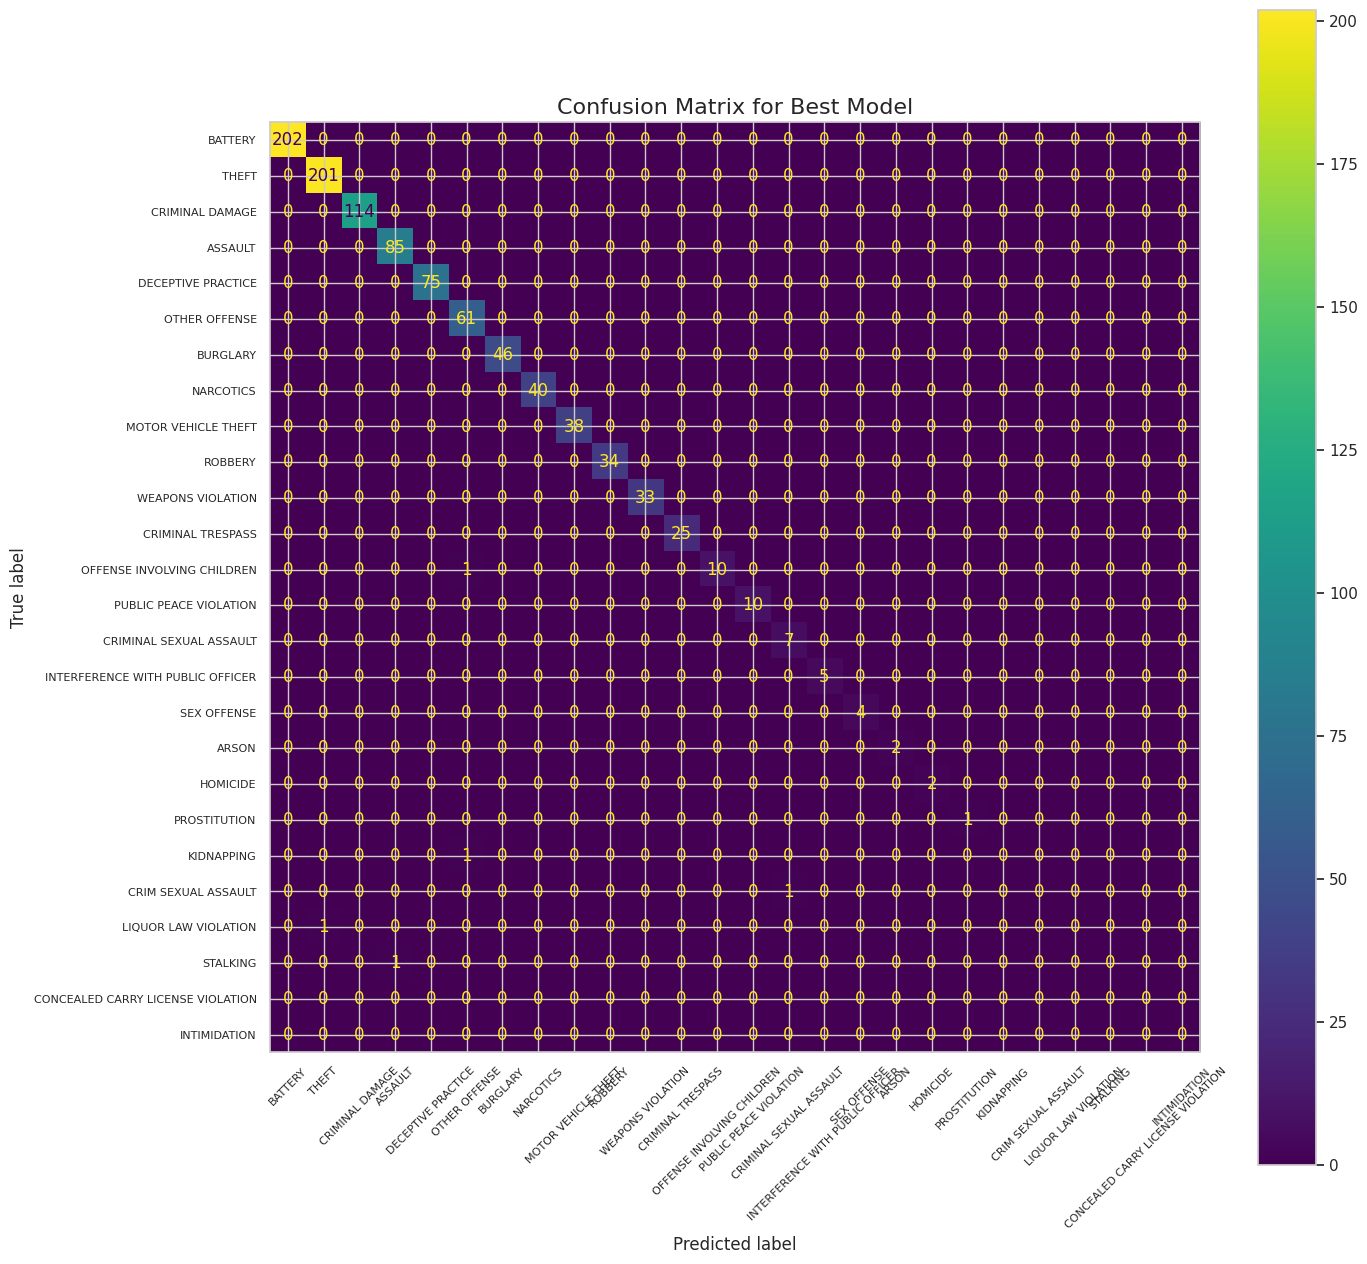

In [20]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Step 5: Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 6: Hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(estimator=baseline_model, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

print("Best hyperparameters:", grid_search.best_params_)

# Step 7: Validation performance
y_pred = best_model.predict(X_val)
print("Validation Accuracy:", best_model.score(X_val, y_val))
print("Classification Report:\n", classification_report(y_val, y_pred))

# Step 8: Display improved confusion matrix
fig, ax = plt.subplots(figsize=(15, 15))
sorted_labels = y.value_counts().index  # Sort labels by frequency
conf_matrix = confusion_matrix(y_val, y_pred, labels=sorted_labels)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=sorted_labels)
disp.plot(cmap='viridis', xticks_rotation=45, ax=ax)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.title("Confusion Matrix for Best Model", fontsize=16)
plt.xlabel("Predicted label", fontsize=12)
plt.ylabel("True label", fontsize=12)
plt.show()


### 11. Identifying Potential Pitfalls and Analyzing Model Performance

This shell evaluates misclassifications, feature importance, and overfitting risks to identify potential pitfalls in the model.


Training Accuracy: 1.00
Validation Accuracy: 0.99


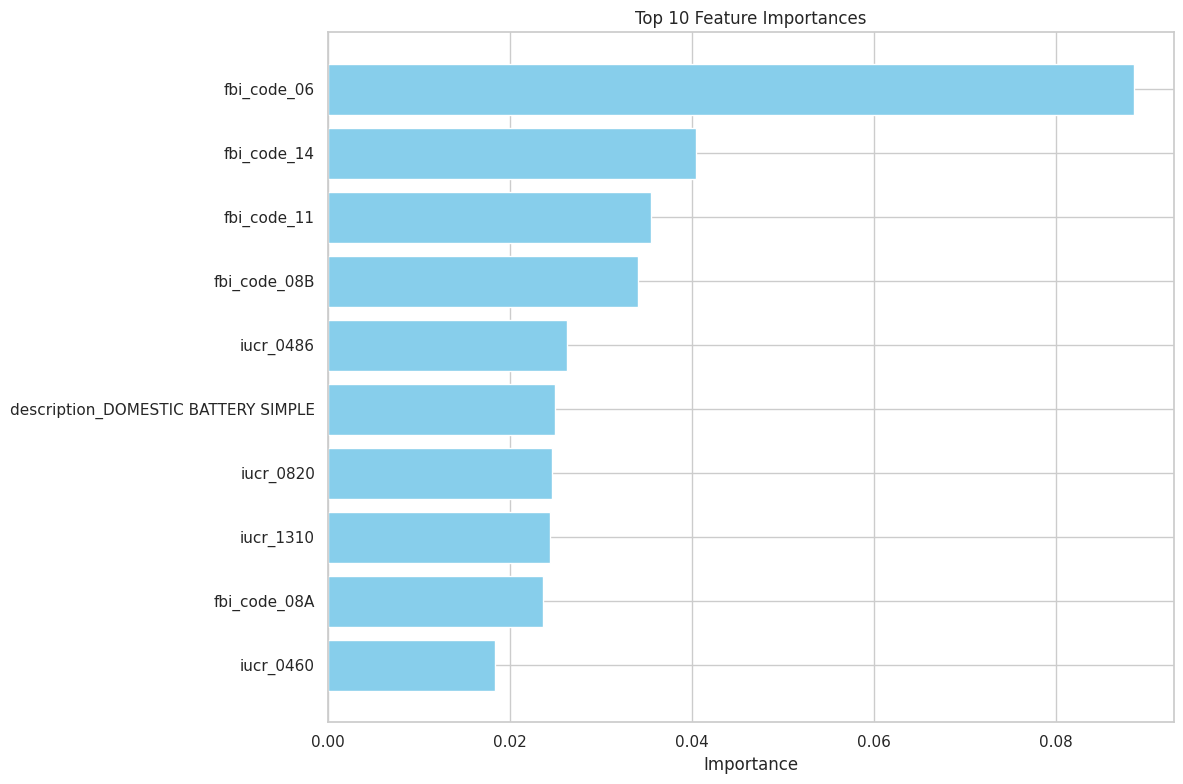

Total number of misclassified samples: 5
Examples of misclassifications:
True: STALKING, Predicted: ASSAULT
True: KIDNAPPING, Predicted: OTHER OFFENSE
True: LIQUOR LAW VIOLATION, Predicted: THEFT
True: CRIM SEXUAL ASSAULT, Predicted: CRIMINAL SEXUAL ASSAULT
True: OFFENSE INVOLVING CHILDREN, Predicted: OTHER OFFENSE


In [26]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Step 1: Check for overfitting by comparing train and validation scores
train_accuracy = best_model.score(X_train, y_train)
val_accuracy = best_model.score(X_val, y_val)
print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Validation Accuracy: {val_accuracy:.2f}")

if train_accuracy - val_accuracy > 0.1:
    print("Potential Overfitting: Model performs significantly better on training data than validation data.")

# Step 2: Analyze feature importance
if hasattr(best_model, "feature_importances_"):
    importances = best_model.feature_importances_
    sorted_indices = np.argsort(importances)[::-1]
    feature_names = list(X_numeric.columns) + encoder.get_feature_names_out().tolist()

    # Plot top 10 feature importances with better visualization
    plt.figure(figsize=(12, 8))
    plt.barh([feature_names[i] for i in sorted_indices[:10]], importances[sorted_indices[:10]], color='skyblue')
    plt.gca().invert_yaxis()
    plt.title("Top 10 Feature Importances")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()
else:
    print("Feature importance not available for the selected model.")

# Step 3: Analyze misclassifications
misclassified = np.where(y_val != y_pred)[0]

# Display the total count of misclassified samples
print(f"Total number of misclassified samples: {len(misclassified)}")

# Show 5 examples of misclassifications
if len(misclassified) > 0:
    print("Examples of misclassifications:")
    for idx in misclassified[:5]:  # Show up to 5 examples
        print(f"True: {y_val.iloc[idx]}, Predicted: {y_pred[idx]}")
else:
    print("No misclassifications found in the validation set.")



### Experiment 1: Feature Selection (To improve Model's Performance)

In this experiment, we will perform feature selection to reduce potential noise in the data and enhance model performance. By selecting the most important features, we may be able to achieve better accuracy and interpretability.

In [27]:
# Experiment 1: Feature Selection - Retaining Top Features Based on Importance
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

# Step 1: Train a RandomForest model to get feature importances
selector_model = RandomForestClassifier(random_state=42)
selector_model.fit(X_train, y_train)

# Step 2: Select features with importance above a threshold (mean importance here)
sfm = SelectFromModel(selector_model, threshold="mean", prefit=True)
X_train_selected = sfm.transform(X_train)
X_val_selected = sfm.transform(X_val)

# Step 3: Train a new model using only the selected features
selected_model = RandomForestClassifier(random_state=42)
selected_model.fit(X_train_selected, y_train)

# Step 4: Validate and evaluate the performance
y_pred_selected = selected_model.predict(X_val_selected)
print("Validation Accuracy with Feature Selection:", selected_model.score(X_val_selected, y_val))
print("Classification Report with Feature Selection:\n", classification_report(y_val, y_pred_selected))


Validation Accuracy with Feature Selection: 0.994
Classification Report with Feature Selection:
                                   precision    recall  f1-score   support

                           ARSON       1.00      1.00      1.00         2
                         ASSAULT       0.99      1.00      0.99        85
                         BATTERY       1.00      1.00      1.00       202
                        BURGLARY       1.00      1.00      1.00        46
             CRIM SEXUAL ASSAULT       0.00      0.00      0.00         1
                 CRIMINAL DAMAGE       1.00      1.00      1.00       114
         CRIMINAL SEXUAL ASSAULT       0.88      1.00      0.93         7
               CRIMINAL TRESPASS       1.00      1.00      1.00        25
              DECEPTIVE PRACTICE       1.00      1.00      1.00        75
                        HOMICIDE       1.00      1.00      1.00         2
INTERFERENCE WITH PUBLIC OFFICER       1.00      0.80      0.89         5
              

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Experiment 2: Logistic Regression with Lasso and Ridge Regularization

In this experiment, we train logistic regression models with L1 (Lasso) and L2 (Ridge) regularization to understand their impact on the dataset.

L1 (Lasso): Performs feature selection by shrinking coefficients of irrelevant features to zero.
L2 (Ridge): Reduces overfitting by penalizing large coefficients without eliminating features. The goal is to compare their performance using validation accuracy and classification reports.

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Step 1: Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 2: Logistic Regression with L1 (Lasso)
lasso_model = LogisticRegression(penalty='l1', solver='liblinear', C=1.0, random_state=42)
lasso_model.fit(X_train, y_train)

# Step 3: Logistic Regression with L2 (Ridge)
ridge_model = LogisticRegression(penalty='l2', solver='liblinear', C=1.0, random_state=42)
ridge_model.fit(X_train, y_train)

# Step 4: Evaluate Lasso Model
y_pred_lasso = lasso_model.predict(X_val)
lasso_accuracy = lasso_model.score(X_val, y_val)
print(f"Validation Accuracy (Lasso): {lasso_accuracy:.2f}")
print("Classification Report (Lasso):\n", classification_report(y_val, y_pred_lasso))

# Step 5: Evaluate Ridge Model
y_pred_ridge = ridge_model.predict(X_val)
ridge_accuracy = ridge_model.score(X_val, y_val)
print(f"Validation Accuracy (Ridge): {ridge_accuracy:.2f}")
print("Classification Report (Ridge):\n", classification_report(y_val, y_pred_ridge))


Validation Accuracy (Lasso): 1.00
Classification Report (Lasso):
                                   precision    recall  f1-score   support

                           ARSON       1.00      1.00      1.00         2
                         ASSAULT       0.99      1.00      0.99        85
                         BATTERY       1.00      1.00      1.00       202
                        BURGLARY       1.00      1.00      1.00        46
             CRIM SEXUAL ASSAULT       0.00      0.00      0.00         1
                 CRIMINAL DAMAGE       1.00      1.00      1.00       114
         CRIMINAL SEXUAL ASSAULT       0.88      1.00      0.93         7
               CRIMINAL TRESPASS       1.00      1.00      1.00        25
              DECEPTIVE PRACTICE       1.00      1.00      1.00        75
                        HOMICIDE       1.00      1.00      1.00         2
INTERFERENCE WITH PUBLIC OFFICER       1.00      1.00      1.00         5
                      KIDNAPPING       0.00  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m